# branch: lstm readout + drifting context
- context drifts with fixed step size in random direction. try between episode randomization.
- memory keys are same as memory values: concatenated context-stimulus vectors
- order for feed into readout given by similarity of query to key 

In [1]:
import numpy as np
import tensorflow as tf

from pureEM import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


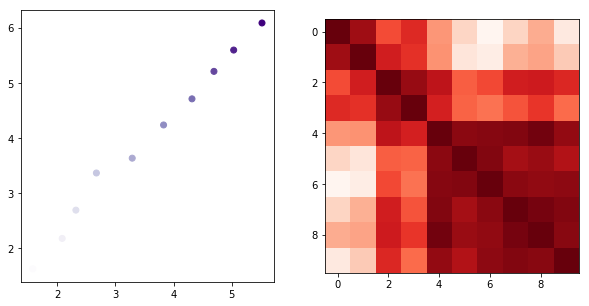

In [2]:
## sample new context emat
def generate_context_drift(ntrials,context_edim):
  delta_std = .3
  delta_mean = 1
  alpha = .5
  arr = -np.ones([ntrials,context_edim])
  v_t = np.random.normal(delta_mean,delta_std,context_edim)
  for step in range(ntrials):
    delta_t = np.random.normal(delta_mean,delta_std,context_edim)
    v_t += alpha*delta_t
    arr[step] = v_t
  return arr
  
context_arr = generate_context_drift(10,10)

fig,axarr = plt.subplots(1,2,figsize=(10,5));axarr=axarr.reshape(-1)
axarr[0].scatter(context_arr[:,0],context_arr[:,1],c=np.arange(len(context_arr)),cmap=plt.get_cmap('Purples'))
axarr[1].imshow(np.corrcoef(context_arr),cmap=plt.get_cmap('Reds'))
plt.savefig('figures/pureem-drifting_context/context_drift_sample')

## training

In [23]:
def train_loop(net,task,epochs,sess_context,sess_stim):
  """
  training with randomly drifting context
  """
  L = -1*np.ones(epochs)
  A = -1*np.ones(epochs)
  for ep in range(epochs):
    if ep%sess_stim==0:
      print('rand stim emat')
      net.sess.run(net.randomize_stim_emat)
    if ep%sess_context==0:
      context_emat = generate_context_drift(net.ntrials,net.context_edim)
    
    T,X,Y = task.gen_episode_data()
    feed_dict = {
      net.trial_ph:T,
      net.stim_ph:X,
      net.y_ph:Y,
      net.context_emat_ph:context_emat
    }
    ops = [
      net.minimizer,
      net.train_loss,
      net.response,
    ]
    # record loss and accuracy
    outs = net.sess.run(ops,feed_dict)
    _,loss,yhat = outs

    L[ep] = loss.mean()
    A[ep] = np.mean(yhat==Y[:,2:])
  return L,A


In [24]:
ntrials = 15
nstim = 3
dim = 20
stim_edim = 5
context_edim = 5

net = PureEM(nstim,ntrials,dim,stim_edim,context_edim)
task = NBackTask(nstim=nstim,ntrials=ntrials,flip_pr=.35)

-- proportion of true trials: M=0.50 S=0.12


In [25]:
epochs = 200000
sess_stim = 10000
sess_context = 1
train_loss,train_acc = train_loop(net,task,epochs,sess_context,sess_stim)

rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat
rand stim emat


Text(0.5,1,'drifting context, non-trainable orthogonal stim embeddings ')

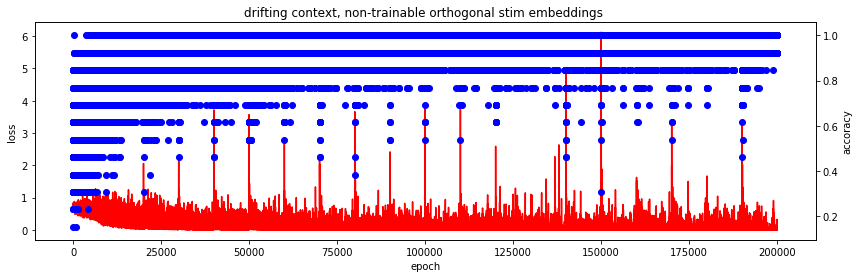

In [26]:
plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(train_loss,c='r')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')

ax2 = ax.twinx()
ax2.scatter(range(len(train_acc)),train_acc,c='b')
ax2.set_ylabel('accoracy')
# for t in range(0,epochs,sesslen):
#   ax.axvline(t,c='g')
plt.title('drifting context, non-trainable orthogonal stim embeddings ')

# plt.savefig('figures/pureem-drifting_context/train_lossacc-ntrials_%i-nstim_%i'%(ntrials,nstim))


## eval

In [27]:
nitr = 10000
data = -np.ones([nitr,ntrials-2])
for itr in range(nitr):
  context_emat = generate_context_drift(net.ntrials,net.context_edim)

  T,X,Y = task.gen_episode_data()

  feed_dict = {
    net.trial_ph:T,
    net.stim_ph:X,
    net.y_ph:Y,
    net.context_emat_ph:context_emat
  }
  ops = [
    net.response,
  ]
  
  net.sess.run(net.randomize_stim_emat)
  yhat = net.sess.run(ops,feed_dict)

  data[itr] = (yhat[0] == Y[:,2:]).astype(int)


Text(0.5,1,'mean over 10000 new context drifts + new stimulus representations')

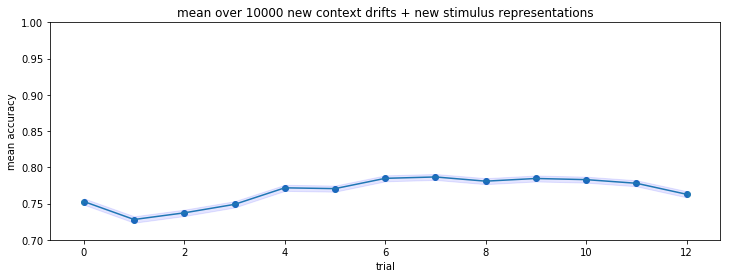

In [29]:
plt.figure(figsize=(12,4))
M = data.mean(0)
S = data.std(0)/np.sqrt(nitr)
plt.plot(M)
plt.scatter(range(len(M)),M)
plt.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='b')
plt.ylabel('mean accuracy')
plt.xlabel('trial')
plt.ylim(0.7,1)
plt.title('mean over 10000 new context drifts + new stimulus representations')
# plt.savefig('figures/pureem-drifting_context/eval_trials-400k_training-stim_heldout')

### inspect learned stim_emat

(5, 5)


array([[ 1.  , -0.03, -0.12,  0.05,  0.01],
       [-0.03,  1.  , -0.43,  0.18,  0.04],
       [-0.12, -0.43,  1.  ,  0.77,  0.15],
       [ 0.05,  0.18,  0.77,  1.  , -0.06],
       [ 0.01,  0.04,  0.15, -0.06,  1.  ]])

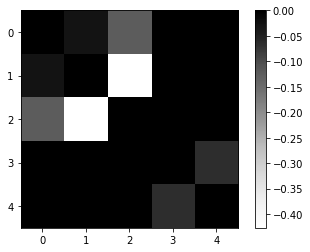

In [86]:
semat = net.sess.run(net.stim_emat)
print(semat.shape)
C = np.corrcoef(semat)
plt.imshow(C,cmap=plt.get_cmap('Greys'),vmax=0)
plt.colorbar()
C.round(2)

### inspect retrieval

In [87]:
seq = [0,1,0,2,0]
T,X,Y = task.format_seq_into_dataset(seq)
context_emat = np.identity(ntrials)
context_emat = np.random.randn(net.ntrials,net.context_edim)

feed_dict = {
  net.trial_ph:T,
  net.stim_ph:X,
  net.y_ph:Y,
  net.context_emat_ph:context_emat
}

L = net.sess.run(net.retrieved_contextsL,feed_dict=feed_dict)
L[2]

array([[[-0.11077335, -0.22799161,  0.31771746,  1.7155287 ,
          0.46887422],
        [-0.        , -0.        ,  0.        , -0.        ,
         -0.        ],
        [-1.087011  ,  0.3404636 ,  0.12392487, -1.2465123 ,
         -1.5236385 ],
        [-0.        , -0.        , -0.        , -0.        ,
          0.        ]]], dtype=float32)

In [88]:
net.sess.run(net.qksimL,feed_dict=feed_dict)

[array([ 1.0000000e+00, -7.8231096e-08], dtype=float32),
 array([-1.8626451e-08, -2.9802322e-08, -1.8626451e-08], dtype=float32),
 array([ 1.0000000e+00, -7.8231096e-08,  1.0000000e+00, -1.8626451e-08],
       dtype=float32)]

### simulating chance

proportion of true trials: M=0.39 S=0.14


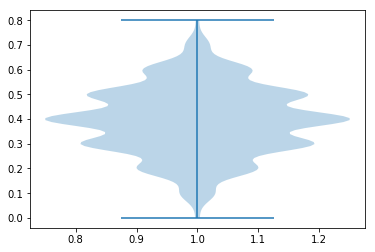

In [749]:
ntrials = 10
nstim = 5
true_nback_pr = .35
task = NBackTask(nstim=nstim,ntrials=ntrials,true_nback_pr=true_nback_pr)

L = []
for i in range(1000):
  T,X,Y = task.gen_episode()
  L.append(Y.sum()/Y.shape[1])

plt.violinplot(L)
print("proportion of true trials: M=%.2f S=%.2f"%(np.mean(L),np.std(L)))

### debugging

In [679]:
ntrials=5
net = PureEM(ntrials=ntrials,dim=2)
# task = NBackTask()
# net.reinitialize()
ntrials=5
for ep in range(1): 
  T,X,Y = task.genseq(ntrials=ntrials)
  feed_dict = {net.trial_ph:T,net.stim_ph:X,net.y_ph:Y}
  ops = [
    net.M_keys,
    net.query_key_sim,
    net.stim,
    net.retrieved_memory,
    net.M_values,
    net.context,
    net.response_in
  ]
  outs = net.sess.run(ops,feed_dict)

Tensor("strided_slice_2:0", shape=(1, 2), dtype=float32)
Tensor("strided_slice:0", shape=(2, 2), dtype=float32)
[1.0, 0.9]
Tensor("strided_slice_4:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write:0", shape=(3, 2), dtype=float32)
[0.9, 1.0, 0.9]
Tensor("strided_slice_6:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write_1:0", shape=(4, 2), dtype=float32)
[0.81, 0.9, 1.0, 0.9]


In [680]:
# stim seq
for x in X.squeeze():
  print(x)

1
2
0
2
2


In [681]:
print('cos')
print(outs[1].round(3))
# s_t

# sim

print('M_K')
print(outs[0])
print('stim_T')
print(outs[2][:,-1])
print('M_V')
print(outs[4])
print('m_T')
print(outs[3])
print('c_T')
print(outs[5][:,-1])
print('x_in')
print(outs[6].reshape(2,-1))

cos
[0.004 0.4   0.196 0.4  ]
M_K
[[ 0.11894773  0.9486887 ]
 [-0.27373168 -0.96113366]
 [-0.6422192   0.66132146]
 [-0.27373168 -0.96113366]
 [-0.27373168 -0.96113366]]
stim_T
[[-0.27373168 -0.96113366]]
M_V
[[ 0.5238827  -0.00179951]
 [-0.33924514  0.18750945]
 [-0.89836234 -0.76285404]
 [-0.7214177  -0.03025485]
 [-0.0098532   0.42147025]]
m_T
[[-0.59812367 -0.08630171]]
c_T
[[-0.0098532   0.42147025]]
x_in
[[-0.0098532   0.42147025]
 [-0.59812367 -0.08630171]]


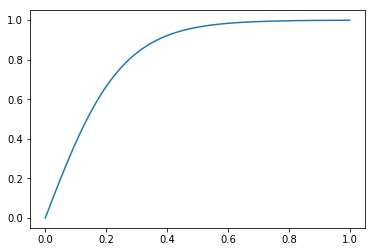

In [592]:
x = np.linspace(0,1,100)
t=4
y=np.tanh(t*x)
plt.plot(x,y)